# 5 - Construindo um LLM do Zero: Bloco Transformer

Este é o **quarto** de uma série de oito artigos que podem ser encontrados no meu medium. Acesse o primeiro artigo da série aqui: [Construindo um LLM: entendendo os Grandes Modelos de Linguagem](https://blog.zfab.me/construindo-um-llm-entendendo-os-grandes-modelos-de-linguagem-b37884219eaa)

----

Os **Transformers** revolucionaram o processamento de linguagem natural. No coração dessa revolução está o **Bloco Transformer**, o módulo central das arquiteturas de LLMs, como a que estamos construindo.

Em nosso artigo anterior, exploramos o famoso **mecanismo de atenção**, um componente central do bloco Transformer. No entanto, este mecanismo sozinho não é suficiente para alcançar os resultados que observamos nos LLMs — precisamos incorporar outros componentes estruturais que, embora mais simples, são cruciais para o funcionamento do modelo.

Vamos examinar quatro elementos fundamentais que, junto com o Multi-Head Attention, compõem o Bloco Transformer:

1. **Camadas de Normalização (Layer Normalization)** – estabilizam o treinamento e aumentam a eficiência da rede.
2. **Ativação GeLU (Gaussian Error Linear Unit)** – Função de ativação usada na FeedForward Network que oferece uma transição mais suave que o ReLU (função comumente usada em redes neurais), melhorando assim a capacidade de aprendizado do modelo.
3. **Camadas FeedForward** – redes neurais dentro de cada bloco Transformer que processam as representações de forma não-linear.
4. **Shortcut Connections (Residual Connections)** – permitem o fluxo direto de informação, prevenindo o problema do Vanishing Gradient.

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

## **O Papel do Bloco Transformer**

Antes de mergulharmos nos detalhes técnicos de cada camada, é essencial entender **onde** esses componentes se encaixam no fluxo de um bloco Transformer.

Um Bloco Transformer é composto por duas seções principais: **Mecanismo de Atenção (Multi-Head Attention)** e **Camada FeedForward**. Cada uma dessas partes é precedida por **Layer Normalization** e seguida por **Shortcut Connections**. O modelo também utiliza camadas de Dropout (como as que vimos no Mecanismo de Atenção) para prevenir overfitting.

![Bloco Transformer](../assets/5-BLOCO.png)

Essa estrutura modular é replicada múltiplas vezes na arquitetura de um Transformer. O **GPT-2** **Small** (com 117M de parâmetros) utiliza 12 blocos de atenção, enquanto o **GPT-2 XL** (com 1.5B de parâmetros) emprega 48 blocos. O processo funciona como uma sequência de blocos idênticos: os tensores entram em um bloco, são processados e seguem para o próximo, que mantém a mesma estrutura..

Agora que temos uma visão geral, vamos explorar os componentes desse bloco

## **Camadas de Normalização (Layer Normalization)**

Redes neurais profundas enfrentam dois grandes desafios durante o treinamento: **Gradientes Explosivos** (Exploding Gradient) – quando os pesos são atualizados de forma exponencial, desestabilizando o treinamento, e **Gradientes Desaparecendo** (Vanishing Gradient) – quando os gradientes se tornam tão pequenos que as camadas iniciais da rede praticamente param de aprender.

Para evitar principalmente o problema do Vanishing Gradient, os Transformers utilizam **Layer Normalization (LayerNorm)**, que normaliza as ativações para que tenham média 0 e variância 1, também conhecida como variância unitária, garantindo que os valores de ativação fiquem em uma escala previsível.

$\text{LayerNorm}(x) = \gamma \cdot x_\text{norm} +\beta = \gamma \cdot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta$

Na equação do LayerNorm mostrada, temos:

- x: é o valor de entrada a ser normalizado
- μ (mu): é a média do vetor de entrada
- σ² (sigma²): é a variância do vetor
- ε (epsilon): é um pequeno valor para evitar divisão por zero

Além disso, LayerNorm possui dois parâmetros treináveis:

- γ (gamma): é um parâmetro treinável que ajusta a escala da normalização
- β (beta): é um parâmetro treinável que adiciona um deslocamento para preservar a expressividade

Esses parâmetros treináveis permitem que a rede ajuste a distribuição dos dados durante o treinamento. O gamma (γ) controla a amplitude da normalização, enquanto o beta (β) permite deslocar os valores normalizados para qualquer média desejada. Isso dá à rede a flexibilidade de aprender a representação mais adequada para cada camada.

Vamos fazer um exemplo, ignorando os parâmetros treináveis por enquanto. Considere 3 tensores de tamanho 6 (que podemos interpretar como 3 tokens com um embedding de dimensão 6). Vamos processar esses tensores através de uma camada linear simples, que retornará os mesmos 3 tensores, porém agora com dimensão 4.

In [3]:
torch.manual_seed(42)

inp = torch.randn(3, 6)
layer = nn.Linear(6, 4)
out = layer(inp)

print(f"Entrada:\n{inp}")
print(f"Saida:\n{out}")

Entrada:
tensor([[ 1.9269,  1.4873, -0.4974,  0.4396, -0.7581,  1.0783],
        [ 0.8008,  1.6806,  0.3559, -0.6866,  0.6105,  1.3347],
        [-0.2316,  0.0418, -0.2516,  0.8599, -0.3097, -0.3957]])
Saida:
tensor([[ 0.3800, -0.5400,  0.5123, -0.4735],
        [ 0.2889, -0.6716,  0.1246,  0.0287],
        [ 0.6655, -0.0524, -0.1044, -0.1135]], grad_fn=<AddmmBackward0>)


Em seguida, se tirarmos a média e a variância desses 3 tensores percebemos que os valores não seguem média zero e variância um.

In [4]:
mean_out = out.mean(dim=-1, keepdim=True)
var_out = out.var(dim=-1, keepdim=True, unbiased=False)

print(f"Média:\n{mean_out}")
print(f"Variância:\n{var_out}")

Média:
tensor([[-0.0303],
        [-0.0574],
        [ 0.0988]], grad_fn=<MeanBackward1>)
Variância:
tensor([[0.2297],
        [0.1344],
        [0.1076]], grad_fn=<VarBackward0>)


É nesse momento que aplicamos a fórmula do LayerNorm para normalizar esses valores. O processo consiste em subtrair a média dos valores e dividir o resultado pela raiz quadrada da variância (também conhecida como desvio padrão)

In [5]:
out_norm = (out - mean_out) / torch.sqrt(var_out)
mean_norm = out_norm.mean(dim=-1, keepdim=True)
var_norm = out_norm.var(dim=-1, keepdim=True, unbiased=False)

torch.set_printoptions(sci_mode=False) # Desabilita a notação científica

print(f"Saida normalizada:\n{out_norm}")
print(f"Média:\n{mean_norm}")
print(f"Variância:\n{var_norm}")

#OUTPUT
#Saida normalizada:
#tensor([[ 0.8560, -1.0633,  1.1320, -0.9247],
#        [ 0.9444, -1.6753,  0.4963,  0.2346],
#        [ 1.7277, -0.4610, -0.6194, -0.6473]], grad_fn=<DivBackward0>)
#Média:
#tensor([[    -0.0000],
#        [     0.0000],
#        [     0.0000]], grad_fn=<MeanBackward1>)
#Variância:
#tensor([[1.0000],
#        [1.0000],
#        [1.0000]], grad_fn=<VarBackward0>)

Saida normalizada:
tensor([[ 0.8560, -1.0633,  1.1320, -0.9247],
        [ 0.9444, -1.6753,  0.4963,  0.2346],
        [ 1.7277, -0.4610, -0.6194, -0.6473]], grad_fn=<DivBackward0>)
Média:
tensor([[    -0.0000],
        [     0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variância:
tensor([[1.0000],
        [1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Agora temos nossos tensores com valores normalizados (média zero e variância unitária). Na fórmula, podemos observar a presença do ε (epsilon) no denominador da divisão.

Este epsilon é um valor minúsculo adicionado para evitar um problema matemático: a divisão por zero que ocorreria caso a variância fosse zero. Para prevenir essa situação, incluímos esse valor infinitesimal no denominador da fórmula.

Vamos agora criar uma classe de LayerNorm usando a formula que vimos acima e adicionando os dois parâmetros treináveis

In [ ]:
class LayerNorm(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.eps = 1e-6  # Epsilon para evitar divisão por zero
        self.scale = nn.Parameter(
            torch.ones(d_emb)
        ) # Gamma - Inicializando com 1 para não alterar a escala
        self.shift = nn.Parameter(
            torch.zeros(d_emb)
        ) # Beta - Inicializando com 0 para não alterar o deslocamento

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift # Gamma * x_norm + Beta

Criamos uma camada que implementa exatamente a fórmula vista anteriormente: ela normaliza os tensores de entrada (subtraindo a média e dividindo pela soma do epsilon com a raiz quadrada da variância), multiplica por Gamma e soma com Beta — parâmetros que a camada aprenderá durante o treinamento.

Inicializamos Gamma e Beta com 1 e 0, respectivamente, para que inicialmente não alterem o resultado, mantendo a média zero e a variância unitária. Durante o treinamento, a rede aprenderá e ajustará esses valores para otimizar a distribuição dos dados de acordo com os resultados esperados.

Vamos passar pela nossa camada de normalização o mesmo tensor que obtivemos anteriormente (3 tensores de tamanho 4)

In [ ]:
ln = LayerNorm(d_emb=4)

out_ln = ln(out)
mean_ln = out_ln.mean(dim=-1, keepdim=True)
var_ln = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print(f"Saida normalizada:\n{out_ln}")
print(f"Média:\n{mean_ln}")
print(f"Variância:\n{var_ln}")

#OUTPUT
# Saida normalizada:
# tensor([[ 0.8560, -1.0633,  1.1320, -0.9247],
#         [ 0.9444, -1.6753,  0.4963,  0.2346],
#         [ 1.7277, -0.4610, -0.6194, -0.6473]], grad_fn=<AddBackward0>)
# Média:
# tensor([[    -0.0000],
#         [     0.0000],
#         [     0.0000]], grad_fn=<MeanBackward1>)
# Variância:
# tensor([[1.0000],
#         [1.0000],
#         [1.0000]], grad_fn=<VarBackward0>)

Saida normalizada:
tensor([[ 0.8560, -1.0633,  1.1320, -0.9247],
        [ 0.9444, -1.6753,  0.4963,  0.2346],
        [ 1.7277, -0.4610, -0.6194, -0.6473]], grad_fn=<AddBackward0>)
Média:
tensor([[    -0.0000],
        [     0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variância:
tensor([[1.0000],
        [1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Como podemos observar, o resultado foi exatamente o esperado: média zero e variância unitária, exatamente igual nossa conta anterior.

Já temos mais um componente para a construção do nosso bloco Transformer. Vamos falar um pouco agora função de ativação GeLU, que usaremos em nossa camada FeedFoward

---

## **Ativação GeLU: Uma Alternativa ao ReLU**

A função de ativação **ReLU (Rectified Linear Unit)** é amplamente utilizada em redes neurais devido à sua simplicidade e eficiência computacional. Ela funciona zerando todos os valores negativos e mantendo os valores positivos inalterados, criando uma relação linear para x > 0.

Embora seja eficiente e útil, a ReLU possui duas limitações principais que podem afetar significativamente o desempenho do modelo:

1. **Morte de Neurônios** – quando valores negativos são completamente descartados (zerados), alguns neurônios podem entrar em um estado onde sempre produzem saída zero, independentemente da entrada. Este fenômeno é conhecido como "dying ReLU". Uma vez neste estado, o neurônio deixa de contribuir para a rede e não recebe atualizações significativas de gradiente, efetivamente "morrendo".
2. **Descontinuidades no Gradiente** – a mudança abrupta na função ReLU em x = 0 cria uma descontinuidade no gradiente. Enquanto para x > 0 o gradiente é 1, para x < 0 o gradiente é 0, sem uma transição suave entre estes estados. Esta característica pode causar saltos bruscos durante o treinamento, potencialmente levando a instabilidades na otimização e dificultando a convergência do modelo para um mínimo ótimo.

Para solucionar esses problemas foi criado a função de ativação **GeLU** (Gaussian Error Linear Unit) que **suaviza a transição entre valores positivos e negativos**. Em vez de simplesmente zerar os valores negativos como a ReLU, a GeLU aplica uma transformação probabilística baseada na distribuição normal.

Esta função pode ser implementada de várias maneiras; a versão exata é definida como:

$\text{GELU}(x) = x \cdot \frac{1}{2} \left( 1 + \text{erf} \left( \frac{x}{\sqrt{2}} \right) \right)$

onde **erf** é a função erro de Gauss

Na prática, no entanto, é comum implementar uma aproximação computacionalmente mais eficiente. A fórmula é aproximada substituindo a função de erro de Gauss pela **tanh** e **um termo cúbico extra** para um ajuste mais preciso, como mostrado abaixo:

$\text{GELU}(x) \approx 0.5x \left( 1 + \tanh \left( \sqrt{\frac{2}{\pi}} \left( x + 0.044715 x^3 \right) \right) \right)$

Vamos implementar essa função para utilizarmos posteriormente em nossa FNN

In [8]:
class GeLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

Como vimos, implementamos a fórmula matemática descrita anteriormente. Para entender melhor a diferença entre as funções de ativação ReLU e GeLU, vamos compará-las visualmente e através de um exemplo

In [9]:
print(f"Valor de ReLU(-1): {nn.ReLU()(torch.tensor(-1.0))}")
print(f"Valor de ReLU(1): {nn.ReLU()(torch.tensor(1.0))}")
print(f"Valor de GeLU(-1): {GeLU()(torch.tensor(-1.0))}")
print(f"Valor de GeLU(1): {GeLU()(torch.tensor(1.0))}")

Valor de ReLU(-1): 0.0
Valor de ReLU(1): 1.0
Valor de GeLU(-1): -0.15880802273750305
Valor de GeLU(1): 0.8411920070648193


Podemos observar que, diferentemente da ReLU que zera imediatamente qualquer valor negativo, a GeLU apresenta um comportamento mais gradual na transição para zero com valores negativos.

Podemos ver no gráfico abaixo essa transição mais gradual

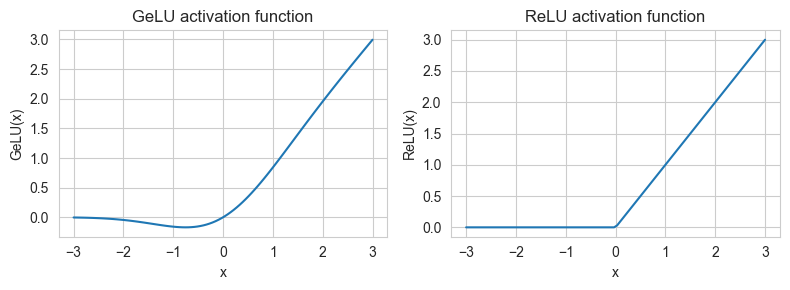

In [10]:
gelu, relu = GeLU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GeLU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
plt.tight_layout()
plt.show()


Com a função de ativação criada podemos usa-la na nossa FFN

## **Camada FeedForward**

Se o mecanismo de atenção é responsável por capturar relações entre tokens e encontrar dependências no texto, as **camadas FeedForward** têm o papel de processar e refinar essas informações.

A FeedForward Network (FFN) dentro do Bloco Transformer é uma **MLP (Multi-Layer Perceptron)** simples, aplicada a cada embedding. A estrutura típica da FeedForward é composta por três etapas:

1. **Expansão dimensional**: a entrada é projetada para um espaço maior (tipicamente 4 vezes o tamanho original).
2. **Aplicação da ativação não-linear**: geralmente **GeLU**.
3. **Redução dimensional**: o vetor é projetado de volta ao tamanho original.

A **expansão da dimensionalidade** permite que a rede capture **relações mais ricas** e represente padrões mais complexos. Mesmo que a entrada e a saída tenham o mesmo tamanho, esse aumento temporário de dimensionalidade cria um **espaço de representação mais expressivo**, permitindo que o modelo aprenda transformações mais sofisticadas.

![FFN](../assets/5-FFN.png)

Esse conceito é semelhante ao que acontece em redes convolucionais, onde camadas intermediárias frequentemente expandem as dimensões antes de reduzi-las para capturar características mais complexas.

A implementação da camada FeedForward é bem simples e direta:

In [ ]:
class FeedForward(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(d_emb, d_emb * 4),
            GeLU(),
            nn.Linear(d_emb * 4, d_emb),
        )

    def forward(self, x):
        return self.layers(x)

Os tensores de entrada (embeddings já enriquecidos com informações da camada de atenção) são expandidos para uma dimensão 4 vezes maior, processados pela função de ativação GeLU e então reduzidos de volta à dimensão original

Vamos aplicar nossa rede em um exemplo, simulando 3 tokens com embedding de dimensão 5

In [12]:
ffn = FeedForward(5)
x = torch.rand(1, 3, 5)
out = ffn(x)

print(f"Entrada:\n{x.shape}:\n{x}")
print(f"Saida:\n{out.shape}:\n{out}")

#OUTPUT
# Entrada:
# torch.Size([1, 3, 5]):
# tensor([[[0.8126, 0.8039, 0.8412, 0.3161, 0.8035],
#          [0.5878, 0.1089, 0.9980, 0.0460, 0.3832],
#          [0.4469, 0.3190, 0.6802, 0.9577, 0.2851]]])
# Saida:
# torch.Size([1, 3, 5]):
# tensor([[[ 0.0742,  0.1719,  0.3859,  0.1599, -0.0456],
#          [ 0.0004,  0.1286,  0.3183,  0.1642,  0.0730],
#          [ 0.0759,  0.2067,  0.2459,  0.1798,  0.0152]]],
#        grad_fn=<ViewBackward0>)

Entrada:
torch.Size([1, 3, 5]):
tensor([[[0.9103, 0.9192, 0.4216, 0.4431, 0.2959],
         [0.0485, 0.0134, 0.6858, 0.2255, 0.1786],
         [0.4610, 0.3335, 0.3382, 0.5161, 0.3939]]])
Saida:
torch.Size([1, 3, 5]):
tensor([[[-0.0484, -0.0415, -0.2401, -0.1088, -0.2168],
         [-0.0806, -0.1796, -0.0340, -0.0024, -0.1243],
         [-0.0695, -0.0466, -0.1623, -0.0761, -0.1887]]],
       grad_fn=<ViewBackward0>)


Podemos ver que após passar pela FFN nossos tokens mantêm o mesmo tamanho, mas os valores foram modificados, pois a rede agora tem uma nova oportunidade de encontrar relações úteis nos valores para o resultado final.

Agora falta apenas um detalhe para podermos construir nosso bloco Transformer: vamos falar sobre atalhos!

---

## **Shortcut Connections: Mantendo o Fluxo do Gradiente**

Modelos de deep learning frequentemente enfrentam um problema que mencionamos antes: o **vanishing gradients**. À medida que o gradiente do erro se propaga de volta pela rede, ele vai diminuindo, o que prejudica o aprendizado das camadas iniciais.

Para mitigar esse problema, utilizamos **shortcut connections** (também chamadas de **residual connections**). Elas foram introduzidas originalmente na arquitetura **ResNet** e rapidamente adotadas em diversas outras redes por sua eficiência.

A ideia central das shortcut connections é simples: ao invés de apenas processar a entrada com uma transformação não-linear, adicionamos um **atalho** somando a entrada original à saída da transformação.

Essa técnica garante que, se a transformação f(x) for ineficaz em algum momento do treinamento, o gradiente **ainda poderá fluir diretamente pela conexão residual**, evitando que desapareça.

Pense nesses atalhos como empurrões que mantêm o gradiente fluindo – periodicamente, damos um impulso ao sinal, evitando que ele se dissipe.

Para demonstrar o impacto dos atalhos, vamos criar uma rede neural fictícia com múltiplas camadas lineares, adicionando atalhos a cada 10 camadas.

In [138]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, n_layers, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        
        # Create layers based on layer_sizes list
        self.layers = nn.ModuleList()

        for i in range(n_layers-1):
            self.layers.append(
                nn.Sequential(
                    nn.Linear(3, 3),
                    GeLU()
                )
            )

        self.layers.append(nn.Linear(3, 1))

    def forward(self, x):
        shortcut = x  # Initial shortcut connection
        for i, layer in enumerate(self.layers):
            layer_output = layer(x)
            
            if self.use_shortcut and i > 0 and (i % 10 == 0) and x.shape == layer_output.shape:
                x = layer_output + shortcut
                shortcut = x  # Update shortcut for next block
            else:
                x = layer_output
                
        return x


Agora vamos criar duas redes com 50 camadas, uma adicionaremos o Shortcut e na outra não

In [139]:
layer_sizes = 50
sample_input = torch.randn(1, 3)
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)

Agora vamos criar uma função que avalia o fluxo do gradiente através das camadas da rede. A função recebe um modelo e um tensor x como entrada, e retorna a média dos gradientes para cada camada de peso na rede.

Não precisamos nos aprofundar nos detalhes desta função agora. Ela existe apenas para visualizarmos o efeito dos Shortcuts nos gradientes da rede. Lembre-se: quanto menor o gradiente, mais difícil é para a rede aprender, pois começamos a lidar com valores muito pequenos que podem chegar a zero.

In [140]:
def mean_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.0]])

    loss = nn.MSELoss()
    loss = loss(output, target)

    loss.backward()

    grad_values = []

    for name, param in model.named_parameters():
        if "weight" in name:
            mean_grad = param.grad.abs().mean().item()
            grad_values.append(mean_grad)

    return grad_values

grads_without = mean_gradients(model_without_shortcut, sample_input)
grads_with = mean_gradients(model_with_shortcut, sample_input)

Vamos visualizar como os gradientes se distribuem ao longo das 50 camadas após calcularmos o erro e sua propagação

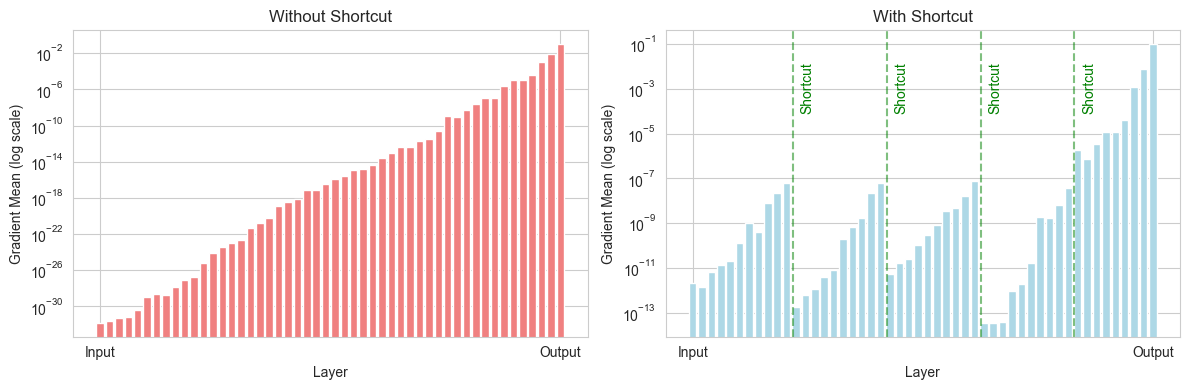

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

x = list(range(len(grads_without)))

# Plot without shortcut
ax1.bar(x, grads_without, color="lightcoral")
ax1.set_yscale('log')
ax1.set_ylabel('Gradient Mean (log scale)')
ax1.set_xlabel('Layer')
ax1.set_title('Without Shortcut')

# Plot with shortcut
ax2.bar(x, grads_with, color="lightblue")
ax2.set_yscale('log')
ax2.set_ylabel('Gradient Mean (log scale)')
ax2.set_xlabel('Layer')
ax2.set_title('With Shortcut')

# Add vertical lines and "Shortcut" text for shortcut connections in ax2
for i in range(10, len(x), 10):
    ax2.axvline(x=i+0.65, color='green', linestyle='--', alpha=0.5)
    ax2.text(i+1.5, ax2.get_ylim()[1] - 0.4, 'Shortcut', rotation=90, verticalalignment='top', color='green')

# Para cada subplot
for ax in [ax1, ax2]:
    ax.set_xticks([0, len(grads_without) - 1])
    ax.set_xticklabels(["Input", "Output"])

plt.tight_layout()
plt.show()


O gráfico mostra a média absoluta dos gradientes em cada camada, e devemos analisá-lo da direita para a esquerda, acompanhando o fluxo do Backpropagation.

O Backpropagation é o processo pelo qual a rede neural ajusta seus pesos durante o treinamento. O gradiente indica quanto cada peso contribuiu para o erro, e usamos essa informação para ajustar os pesos — quanto menor o gradiente, menor será o ajuste. Quando o gradiente se torna muito pequeno, a rede deixa de atualizar os pesos e, consequentemente, para de aprender.

Em redes com muitas camadas, existe uma tendência natural de diminuição dos gradientes, pois os valores pequenos tornam-se ainda menores conforme retrocedem pela rede.

Na rede com shortcuts, embora essa tendência de diminuição persista, cada atalho oferece um impulso que eleva o gradiente, impedindo sua redução excessiva e mantendo a capacidade de aprendizado da rede.

No nosso bloco transformers teremos dois atalhos, um que conectará a entrada da camada de atenção com sua saída (após aplicar dropout), e outro que conectará a entrada da camada FeedForward com sua saída (após aplicação novamente do dropout).

Com isso, temos todas as peças para montarmos nosso Bloco Transformer

---

## **Finalmente, o Bloco!**

Agora podemos consolidar todos esses elementos em um **Bloco Transformer** completo. O bloco portante será composto por

1. **LayerNorm** antes da Multi-Head Attention
2. **Atenção Multi-Head**.
3. **Dropout** antes do Shortcut
4. **Shortcut Connection** (somando a entrada original).
5. **LayerNorm** antes da FeedForward.
6. **Camada FeedForward**.
7. **Dropout** antes do Shortcut
8. **Shortcut Connection**.

In [132]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(
        self, d_in, d_out, context_length, n_heads, qkv_bias=False, dropout=0.1
    ):
        super().__init__()

        assert d_out % n_heads == 0, "d_out deve ser divisível por num_heads"

        self.d_out = d_out
        self.n_heads = n_heads
        self.d_head = d_out // n_heads

        self.W_query = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = torch.nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = torch.nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = torch.nn.Linear(d_out, d_out)
        self.dropout = torch.nn.Dropout(dropout)

        self.register_buffer(
            "mask", torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        n_batch, n_tokens, _ = x.size()

        queries = self.W_query(x)
        keys = self.W_key(x)
        values = self.W_value(x)

        queries = queries.view(n_batch, n_tokens, self.n_heads, self.d_head)
        keys = keys.view(n_batch, n_tokens, self.n_heads, self.d_head)
        values = values.view(n_batch, n_tokens, self.n_heads, self.d_head)

        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        attention_scores = queries @ keys.transpose(-2, -1)
        attention_scores.masked_fill_(
            self.mask.bool()[:n_tokens, :n_tokens], -torch.inf
        )

        attention_weights = torch.softmax(
            attention_scores / keys.size(-1) ** 0.5, dim=-1
        )
        attention_weights = self.dropout(attention_weights)

        context_vector = (attention_weights @ values).transpose(1, 2)
        context_vector = context_vector.contiguous().view(n_batch, n_tokens, self.d_out)
        context_vector = self.out_proj(context_vector)

        return context_vector


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, d_emb, n_heads, context_length, dropout=0.1, qkv_bias=False):
        super().__init__()
        self.mha = MultiHeadAttention(
            d_in=d_emb,
            d_out=d_emb,
            context_length=context_length,
            n_heads=n_heads,
            dropout=dropout,
            qkv_bias=qkv_bias,
        )
        self.ff = FeedForward(d_emb)
        self.norm1 = LayerNorm(d_emb)
        self.norm2 = LayerNorm(d_emb)
        self.drop_shortcut = nn.Dropout(dropout)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x) #1
        x = self.mha(x) #2
        x = self.drop_shortcut(x) #3
        x = x + shortcut #4

        shortcut = x
        x = self.norm2(x) #5
        x = self.ff(x) #6
        x = self.drop_shortcut(x) #7
        x = x + shortcut #8
        return x


Como podemos ver, o bloco transformer é simples de criar quando já temos todas as peças criadas. Vamos testa-lo

In [ ]:
torch.manual_seed(42)
x = torch.rand(2, 4, 768)
block = TransformerBlock(
    d_emb=768, n_heads=12, context_length=4, dropout=0.1, qkv_bias=False
)
output = block(x)

print(f"Entrada:\n{x.shape}:\n{x}")
print(f"Saida:\n{output.shape}:\n{output}")

#OUTPUT
# Entrada:
# torch.Size([2, 4, 768]):
# tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
#          [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
#          [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
#          [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],
# 
#         [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
#          [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
#          [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
#          [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
# Saida:
# torch.Size([2, 4, 768]):
# tensor([[[-0.0056,  0.0972, -0.1122,  ...,  1.2890,  0.2623,  0.6685],
#          [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
#          [ 0.4672,  0.4472,  0.1791,  ...,  1.2526,  0.3045,  0.7750],
#          [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7016]],
# 
#         [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5035],
#          [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  0.5419,  0.1143],
#          [ 0.7425,  0.4013,  0.3211,  ...,  0.3268,  0.7523, -0.1642],
#          [ 0.5745,  0.6241,  0.4410,  ...,  1.1963,  1.2650,  0.2243]]],
#        grad_fn=<AddBackward0>)


Entrada:
torch.Size([2, 4, 768]):
tensor([[[0.2961, 0.5166, 0.2517,  ..., 0.9541, 0.8567, 0.4604],
         [0.2238, 0.3047, 0.3019,  ..., 0.5465, 0.4532, 0.7598],
         [0.6945, 0.2478, 0.4111,  ..., 0.8838, 0.4898, 0.5963],
         [0.0890, 0.7804, 0.9223,  ..., 0.4507, 0.6357, 0.5833]],

        [[0.5716, 0.9297, 0.3396,  ..., 0.0477, 0.4564, 0.2797],
         [0.0936, 0.2211, 0.3806,  ..., 0.3948, 0.4545, 0.4536],
         [0.6788, 0.1741, 0.2084,  ..., 0.5557, 0.5930, 0.0959],
         [0.3894, 0.4083, 0.0662,  ..., 0.9861, 0.9341, 0.1319]]])
Saida:
torch.Size([2, 4, 768]):
tensor([[[-0.0056,  0.0972, -0.1122,  ...,  1.2890,  0.2623,  0.6685],
         [ 0.0023, -0.2369,  0.1720,  ...,  0.5952,  0.2497,  0.7447],
         [ 0.4672,  0.4472,  0.1791,  ...,  1.2526,  0.3045,  0.7750],
         [ 0.0662,  0.7224,  0.9206,  ...,  0.4790,  0.7428,  0.7016]],

        [[ 0.3622,  1.2144,  0.5221,  ...,  0.1854,  0.0111, -0.5035],
         [-0.0225,  0.7789,  0.2770,  ...,  0.1734,  

Criamos tensores de entrada que simulam o tipo e formato de dados que nosso bloco encontrará na prática: 2 batches (2 frases) contendo 4 tokens cada, com embedding de 768 dimensões.

Após o processamento pelo bloco transformer, a saída mantém a mesma estrutura dimensional. Em outras palavras, nossas frases de 4 tokens preservam seu formato original, mas agora contêm representações enriquecidas pelo processamento do bloco transformer.

Nos modelos GPT, esse bloco é empilhado diversas vezes. Cada um desses blocos irá capturar representações mais profundas e refinadas dos tokens, permitindo que o modelo aprenda a prever a próxima palavra de maneira mais eficiente.

---

## **Conclusão**

Neste artigo, concluímos a montagem do Bloco Transformer, explorando seus componentes fundamentais e suas contribuições para o funcionamento do modelo. A normalização de camadas provou ser essencial para a estabilidade do treinamento, enquanto a ativação GeLU trouxe avanços significativos sobre a tradicional ReLU. A rede FeedForward demonstrou seu papel vital na transformação dos embeddings, identificando relações que o mecanismo de atenção ocasionalmente não detecta.

As conexões de atalho (shortcuts) mostraram-se cruciais para preservar a eficiência do gradiente através das camadas, potencializando o aprendizado do modelo. Esses componentes funcionam em sinergia, formando um bloco de processamento robusto que captura sutilezas nas relações entre palavras e produz representações contextuais sofisticadas.

Com o Bloco Transformer dominado, estamos preparados para a próxima etapa: no próximo artigo, vamos integrar todas as peças para construir nosso modelo GPT e prepará-lo para a fase de pré-treino!